In [15]:
import dgl
from rdkit import Chem
Chem.Draw.IPythonConsole.ipython_3d = True  # enable py3Dmol inline visualization
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from typing import List, Tuple
from molecule_builder import graph_to_rdmol

%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
from gnn import MoleculeRegressor
import math

import py3Dmol

# How we represent a graph?

DGL provides a class called `DGLGraph` to represent a graph. [Here is the documentation for the `DGLGraph` class](https://docs.dgl.ai/en/latest/api/python/dgl.DGLGraph.html)

A graph has nodes and it has edges. All graphs in DGL are **directed**. This means that edges have a direction; every edge starts at a source node and ends at a destination node. This means that the edge $i \to j$ is not the same edge as $j \to i$.

It is important understand precisely how we represent the edges of a graph. Every node has a unique ID, or index, which is an integer. We can refer to a node by its index. Edges are represented in terms of the indicies of the source and destination nodes. For example, the edge $(0,2)$ is an edge that starts at node 0 and ends at node 2.

You can get similar information from the [official dgl tutorials](https://docs.dgl.ai/tutorials/blitz/2_dglgraph.html).

In the cell below, we create a simple graph and visualize its structure.

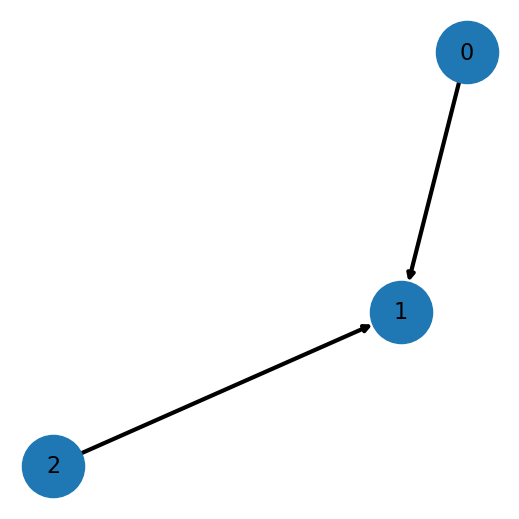

In [18]:
num_nodes = 3 # we will create a graph with 3 nodes

edge_src_idxs = [0, 2] # this is the source node index for every edge
edge_dst_idxs = [1, 1] # this is the destination node index for every edge

g = dgl.graph((edge_src_idxs, edge_dst_idxs), num_nodes=num_nodes)

# show the graph
nx_g = g.to_networkx()
plt.rcParams['font.size'] = 20
plt.figure(figsize=[5,5])
nx.draw(nx_g, with_labels=True, node_size=2000, width=3, font_size=16)
plt.show()

## accessing edges

For a graph that already exists, you can obtain the edges in the representation we just described using `edges` method. 

In [20]:
src_idxs, dst_idxs = g.edges()
print(src_idxs)
print(dst_idxs)

tensor([0, 2])
tensor([1, 1])


# Datasets of Graphs, Representing Molecules as Graphs

We are going to work with a dataset of 3D structures of small molecules + properties of these molecules. The dataset is called QM9. Fortunately, it is available directly through the DGL in a graph format. 

## load the QM9 dataset

Technically this dataset has ~12 scalar-valued quantum mechanical properties for every molecule. But we're just going to load the dataset with one of those labels, $\mu$, the dipole moment of the molecule. 

In [2]:
dataset = dgl.data.QM9EdgeDataset(label_keys=['mu'], raw_dir='data/')

Done loading data from cached files.


# look at the data

In [30]:
dataset_item = dataset[0]
print(f'Each example in the dataset is of type {type(dataset_item)}')
print(f'This tuple has {len(dataset_item)} elements\n\n')
g, label = dataset_item
print(f'The first element is a DGL graph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges')
print(type(g))
print(g,'\n\n')

print(f'The second element is a tensor containing the label for that molecule. In this case, the dipole moment is {label} D')
print(label)

Each example in the dataset is of type <class 'tuple'>
This tuple has 2 elements


The first element is a DGL graph with 5 nodes and 8 edges
<class 'dgl.heterograph.DGLGraph'>
Graph(num_nodes=5, num_edges=8,
      ndata_schemes={'pos': Scheme(shape=(3,), dtype=torch.float32), 'attr': Scheme(shape=(11,), dtype=torch.float32)}
      edata_schemes={'edge_attr': Scheme(shape=(4,), dtype=torch.float32)}) 


The second element is a tensor containing the label for that molecule. In this case, the dipole moment is tensor([0.]) D
tensor([0.])


Each item in the dataset is a tuple of a DGLGraph object and torch tensor with a label for the graph. We can see that this graph has 5 nodes (atoms) and 8 edges (bonds).

## What other types of data is stored in this graph?

We can also see that the graph has a number of node and edge features. The node features are stored in the `ndata` attribute of the graph object and the edge features are stored in the `edata` attribute.

I'm going to run through this by inpecting a graph object itself. But you can also gather more information from [the documentation for the dataset](https://docs.dgl.ai/en/2.0.x/generated/dgl.data.QM9EdgeDataset.html#dgl.data.QM9EdgeDataset) as well as [the preprocessing script](https://gist.github.com/hengruizhang98/a2da30213b2356fff18b25385c9d3cd2) that produced this dataset.

### Lets start by looking at the data attached to nodes.

Node data is stored in the `ndata` attribute of the graph object. This is a dictionary-like object that maps feature names to feature values.

In [31]:
print(g.ndata.keys())

dict_keys(['pos', 'attr'])


In [32]:
print('shape of pos feature:',g.ndata['pos'].shape)
print('shape of attr feature', g.ndata['attr'].shape)

shape of pos feature: torch.Size([5, 3])
shape of attr feature torch.Size([5, 11])


Each node has a position in 3D space. Resulting in a 5x3 tensor.

Each node also has a feature vector of length 11. This is a one-hot encoding of atom type concatenated with some other features such as the hybridization of the atom.

### Lets look at the data attached to every edge

In [33]:
print(g.edata.keys())
print('shape of edge_attr feature:', g.edata['edge_attr'].shape)
print(g.edata['edge_attr'])

dict_keys(['edge_attr'])
shape of edge_attr feature: torch.Size([8, 4])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])


Every edge has a feature vector of length 4 attached to it. This is a one-hot encoding of the type of bond occuring between the two nodes that the edge connects. There are four possible bond types (single, double, triple, and aromatic). In this dataset, atoms only share an edge if they are covelently bonded.

# Visualize Molecules from the Dataset

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

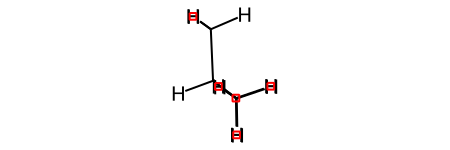

In [5]:
g, _ = dataset[20]

rdmol = graph_to_rdmol(g)
rdmol

# create a dataloader for the data

As we saw previously, each entry in the dataset is a tuple of a dgl graph object and a tensor containing a label for the graph. 

The default behavior of a torch dataloader when collecting/collating samples for a batch is to stack the tensors in the batch along a new dimension. Implicit in this behavior
is the assumption that the dataset class is going to simply return a tensor of tuple of tensors for each sample. 

So, we need to tell the dataloader how to collate the samples. We can do this by defining a custom collate function and passing it to the dataloader.

In [3]:
def labeled_graph_collate_fn(dataset_entries: List[Tuple[dgl.DGLGraph, torch.Tensor]]):
    graphs, labels = zip(*dataset_entries)
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.stack(labels)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=labeled_graph_collate_fn)

now lets inspect what a batch of data looks like!

In [7]:
batch = next(iter(dataloader))

In [8]:
print(f'the type of the batch is {type(batch)}')
print(f'the length of the tuple is {len(batch)}')

print(f'the type of the first element is {type(batch[0])}')
print(f'the type of the second element is {type(batch[1])}')

the type of the batch is <class 'tuple'>
the length of the tuple is 2
the type of the first element is <class 'dgl.heterograph.DGLGraph'>
the type of the second element is <class 'torch.Tensor'>


Each batch is a tuple of 2 objects. These are a `DGLGraph` object and a tensor of labels.

But, this is supposed to be a batch of multiple graphs. How can there be just one graph object?

In [9]:
g, label = batch
print(g)
print(label.shape)

Graph(num_nodes=583, num_edges=1202,
      ndata_schemes={'pos': Scheme(shape=(3,), dtype=torch.float32), 'attr': Scheme(shape=(11,), dtype=torch.float32)}
      edata_schemes={'edge_attr': Scheme(shape=(4,), dtype=torch.float32)})
torch.Size([32, 1])


There are labels for 32 graphs (which is our batch size).

Also notice that the graph object has lots of nodes and edges! Way more than we would expect for a single molecule. This is because the graph object is a batched graph. It is a single graph object that represents multiple graphs. This is a (very important) feature of the `dgl` library.

# Build a graph neural network

Our model will simply do a few graph convolutions, updating the node features at each layer. Then we will pool all the node features by taking their mean. Then a small MLP will predict a scalar value from this pooled representation.

In [20]:
n_node_feats = 11
n_edge_feats = 4
n_hidden_feats = 32
model = MoleculeRegressor(n_node_feats=n_node_feats, n_edge_feats=n_edge_feats, hidden_node_feats=n_hidden_feats, n_convs=2)

# get a batch
batch = next(iter(dataloader))
g, label = batch

print(f'the size of the batch is {g.batch_size}')

predictions = model(g)


print(f'the shape of the predictions is {predictions.shape}')

the size of the batch is 32
the shape of the predictions is torch.Size([32, 1])


# train the GNN

In [19]:
g.edata['edge_attr'].shape[1]

4

In [26]:
# create the model
batch = next(iter(dataloader))
g, label = batch
n_node_feats = 11
n_edge_feats = 4
n_hidden_feats = 32
model = MoleculeRegressor(n_node_feats=n_node_feats, n_edge_feats=n_edge_feats, hidden_node_feats=n_hidden_feats, n_convs=4)


device = 'cuda:0'
model = model.to(device)
max_epochs = 3.0
n_epochs_int = math.ceil(max_epochs)
batch_size = 64
print_interval = 0.1
last_print_marker = 0.0

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=labeled_graph_collate_fn)
loss_fn = nn.MSELoss(reduction='mean')
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
batches_per_epoch = len(dataloader)

batch_losses = []
epoch_vals = []
for epoch_idx in range(n_epochs_int):
    for batch_idx, batch in enumerate(dataloader):

        # compute the epoch as a floating point number
        epoch_exact = epoch_idx + batch_idx / batches_per_epoch
        if epoch_exact > max_epochs:
            break
        epoch_vals.append(epoch_exact)

        optim.zero_grad() # zero the gradients

        # unpack graph, labels and move to the gpu
        g, label = batch
        g = g.to(device)
        label = label.to(device)

        # make predictions
        predictions = model(g)

        # compute loss
        loss = loss_fn(predictions, label)

        # record the loss
        batch_losses.append(loss.item())

        # compute gradients
        loss.backward()
        
        # update model parameters
        optim.step()

        if epoch_exact - last_print_marker > print_interval:
            # compute the average loss over the last 50 batches
            avg_loss = sum(batch_losses[-50:]) / 50
            print(f'epoch {epoch_exact:.2f}, batch {batch_idx}, avg loss {avg_loss:.3f}')
            last_print_marker = epoch_exact


plt.plot(epoch_vals, batch_losses)
plt.show()

epoch 0.10, batch 205, avg loss 2.858
epoch 0.20, batch 410, avg loss 2.841
epoch 0.30, batch 615, avg loss 2.148
epoch 0.40, batch 820, avg loss 1.923
epoch 0.50, batch 1025, avg loss 1.967
epoch 0.60, batch 1230, avg loss 2.050
epoch 0.70, batch 1435, avg loss 1.950
